# Project 3 - Reddit, NLP, and Classification Modeling

### Table of Contents - Quick Links
---

- [Problem Statement](#problem-statement)
- [Libraries](#libraries)
- [Helper Function](#helper-functions)
- [Data Files](#data-files)
- [Feature Engineering](#feature-engineering)
- [EDA](#eda)
- [Modeling](#modeling)

    -[Naive Bayes](#naive-bayes)
    
    -[Random Forest](#random-forest)
    
    -[SVM](#svm)
- [Scoring and Evaluation](#scoring-and-evaluation)
- [Conclusiong and Inferences](#conclusion-and-inferences)

<a id='problem-statement'></a>
### Problem Statement
---

Pulling data from two subreddits, r/ecology and r/environmental_science, can we predict which subreddit our input was written on?  Additionally, what can we infere about each subreddit's post content from processing the language used there.

<a id='libraries'></a>
### Libraries
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

%matplotlib inline

<a id='helper-functions'></a>
### Helper Functions
---

In [34]:
def add_stop_words(stopwords_lst, word_lst):
    '''
    quick way to add stop words to the english stop words list
    '''
    for word in word_lst:
        stopwords_lst.append(word)

In [35]:
def scrape_a_lot(iters, subreddit_name):
    '''
    a function that takes in your desired number of pulls (iterations * 100 posts) 
    and the subreddit name to easily compile and export a csv file containing subreddit 
    name, title, body text, and utc code.
    '''
    url = 'https://api.pushshift.io/reddit/search/submission'
    params = {
        'subreddit': subreddit_name,
        'size': 100,
    }
    res = requests.get(url, params)
    posts = res.json()['data']
    df = pd.DataFrame(posts)[['subreddit', 'title', 'selftext', 'created_utc']]
    for num in range(iters):
        time.sleep(1)
        params = {
        'subreddit': subreddit_name,
        'size': 100,
        'before': df['created_utc'].iloc[-1]
    }
        res = requests.get(url, params)
        posts = res.json()['data']
        df_new = pd.DataFrame(posts)[['subreddit', 'title', 'selftext', 'created_utc']]
        df = pd.concat([df, df_new])
    print(df.shape)
    return df.to_csv('./data/reddit_' + subreddit_name.lower() + '_data.csv')

<a id='data-files'></a>
### Data Files
---

There was minimal cleaning done this data besides dropping body text that was empty and an unneeded index column.

In [2]:
eco_df = pd.read_csv('data/reddit_ecology_data.csv')
eco_df.shape

(7594, 5)

In [3]:
env_df = pd.read_csv('data/reddit_environmental_science_data.csv')
env_df.shape

(5099, 5)

In [38]:
eco_df.dropna(inplace=True)
eco_df.drop(columns=['Unnamed: 0'], inplace=True)
eco_df.shape

(2889, 4)

In [39]:
env_df.dropna(inplace=True)
env_df.drop(columns=['Unnamed: 0'], inplace=True)
env_df.shape

(2970, 4)

In [40]:
eco_df.head()

,subreddit,title,selftext,created_utc
1,ecology,Why isn't plant communication a more popular t...,"I first learned about this in my undergrad, un...",1631303117
4,ecology,Video tutorial on the most important functions...,"Hi everyone, just a quick follow-up to my last...",1631285381
6,ecology,Can you work for a nonprofit with a masters?,I tried to see if another person had asked thi...,1631202355
7,ecology,Does atmospheric humidity enter the gaseous ph...,"From what I understand, the gas phase of soil ...",1631173134
8,ecology,Is biological matter increasing?,"As I understand it, plants and protists kick a...",1631165828


In [41]:
env_df.head()

,subreddit,title,selftext,created_utc
1,environmental_science,College sophomore considering a BA in Environm...,Hi everyone I’m a sophomore and college and I’...,1631044466
2,environmental_science,What modules should I pick career wise?,Hi guys so I'm a third year environmental scie...,1631043893
3,environmental_science,"Graduates of Environmental Science, what have ...",Not strictly about actual science per se... I ...,1631038267
5,environmental_science,Masters Program Advice,"Hi all, I have a bachelors in CS and I'm searc...",1631006821
6,environmental_science,Ecosystem Services Valuation,[removed],1631000441


<a id='feature-engineering'></a>
### Feature Engineering
---

Create word and character count columns for ecology and env science dfs

In [42]:
eco_df['body_char_count'] = [len(x) for x in eco_df['selftext']]
eco_df['body_word_count'] = [len(x.split()) for x in eco_df['selftext']]
eco_df['title_char_count'] = [len(x) for x in eco_df['title']]
eco_df['title_word_count'] = [len(x.split()) for x in eco_df['title']]
eco_df['target'] = 1

In [43]:
env_df['body_char_count'] = [len(x) for x in env_df['selftext']]
env_df['body_word_count'] = [len(x.split()) for x in env_df['selftext']]
env_df['title_char_count'] = [len(x) for x in env_df['title']]
env_df['title_word_count'] = [len(x.split()) for x in env_df['title']]
env_df['target'] = 0

<a id='eda'></a>
### EDA
---

Update our stop words list for ecology using one of our helper functions.  Removing useless words and the title of the subreddit.

In [44]:
eco_stopwords = nltk.corpus.stopwords.words('english')
eco_stopwords_lst = ['ecology', 'www', 'https', 'com', 'amp', 'x200b']

add_stop_words(eco_stopwords, eco_stopwords_lst)

Explore our top 25 single words.

In [45]:
eco_cvec = CountVectorizer(stop_words=eco_stopwords)
eco_x = eco_cvec.fit(eco_df['selftext'])
eco_x = eco_cvec.transform(eco_df['selftext'])
eco_x = pd.DataFrame(eco_x.todense(), columns=eco_cvec.get_feature_names())

eco_x.sum().sort_values(ascending=False).head(25)

would            1486
like             1144
species           896
know              786
work              768
field             699
one               685
get               677
also              664
could             602
research          594
want              581
time              566
anyone            543
help              533
find              514
job               511
looking           494
really            493
environmental     476
much              467
data              455
year              450
thanks            447
experience        423
dtype: int64

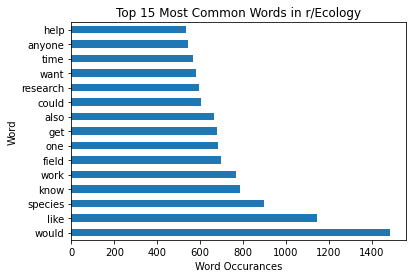

In [46]:
eco_x.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.xlabel('Word Occurances')
plt.ylabel('Word')
plt.title('Top 15 Most Common Words in r/Ecology');

Check out two word n-grams appearing more than twice.

In [47]:
eco_cvec_n = CountVectorizer(stop_words=eco_stopwords, ngram_range=(2,2))
eco_x_n = eco_cvec_n.fit(eco_df['selftext'])
eco_x_n = eco_cvec_n.transform(eco_df['selftext'])
eco_x_n = pd.DataFrame(eco_x_n.todense(), columns=eco_cvec_n.get_feature_names())

eco_x_n.sum().sort_values(ascending=False).head(25)

would like               167
hi everyone              131
climate change           108
feel free                108
open access              104
environmental science    102
grad school               99
field work                93
please feel               92
thanks advance            91
fair game                 87
questions comments        86
find open                 86
discuss article           86
access link               86
article comments          85
free discuss              85
anything remotely         85
like questions            85
comments anything         85
remotely relevant         85
relevant fair             85
comments like             85
onlinelibrary wiley       82
wiley doi                 82
dtype: int64

Update our stop words list for env sci using one of our helper functions.  Removing useless words and the title of the subreddit.

In [48]:
env_stopwords = nltk.corpus.stopwords.words('english')
env_stopwords_lst = ['removed', 'environmental', 'science', 'https', 'www', 'amp', 'x200b']

add_stop_words(env_stopwords, env_stopwords_lst)

In [49]:
env_cvec = CountVectorizer(stop_words=env_stopwords)
env_x = env_cvec.fit(env_df['selftext'])
env_x = env_cvec.transform(env_df['selftext'])
env_x = pd.DataFrame(env_x.todense(), columns=env_cvec.get_feature_names())

env_x.sum().sort_values(ascending=False).head(25)

would         1422
like           900
work           841
job            769
get            717
field          685
know           628
degree         619
want           616
really         550
also           498
school         475
experience     456
anyone         456
looking        451
time           450
one            439
could          437
research       399
career         394
help           391
working        384
year           373
major          359
much           359
dtype: int64

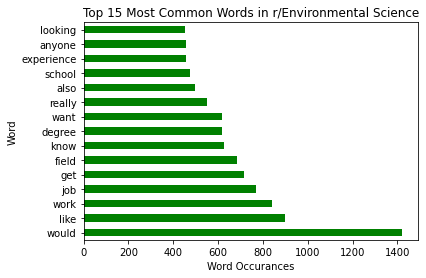

In [50]:
env_x.sum().sort_values(ascending=False).head(15).plot(kind='barh', color='green')
plt.xlabel('Word Occurances')
plt.ylabel('Word')
plt.title('Top 15 Most Common Words in r/Environmental Science');

Check two word n-grams for env science.

In [51]:
env_cvec_n = CountVectorizer(stop_words=env_stopwords, ngram_range=(2,2))
env_x_n = env_cvec_n.fit(env_df['selftext'])
env_x_n = env_cvec_n.transform(env_df['selftext'])
env_x_n = pd.DataFrame(env_x_n.todense(), columns=env_cvec_n.get_feature_names())

env_x_n.sum().sort_values(ascending=False).head(25)

climate change         128
would like             128
feel like               97
field work              80
grad school             77
would love              72
high school             71
entry level             62
thanks advance          60
hi everyone             59
greatly appreciated     59
find job                54
full time               52
wondering anyone        52
would greatly           51
anyone know             49
really want             47
hey guys                47
community college       46
seems like              46
advice would            46
want work               43
get job                 42
think would             40
back school             38
dtype: int64

Compare the top 10 words between our subreddits.  

Words in common:
1. Would
2. Like
3. Work
4. Field
5. Get
6. Know

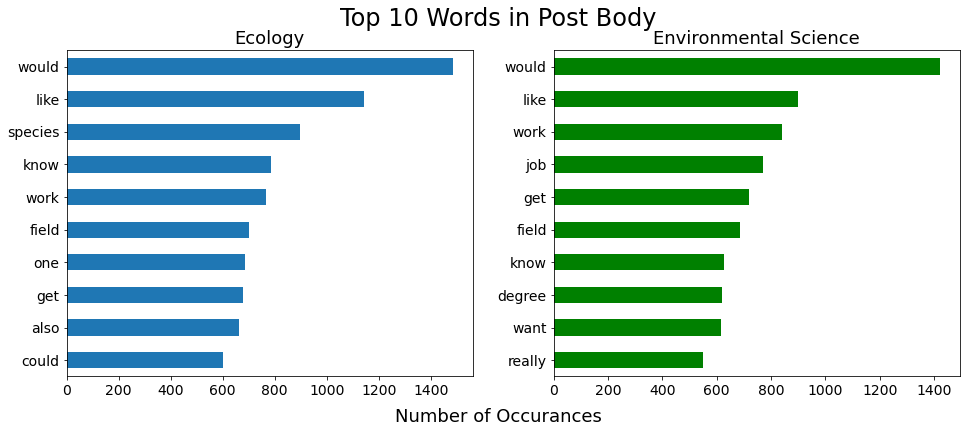

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
eco_x.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0], fontsize=14)
env_x.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1], fontsize=14, color='green')

ax[0].set_title('Ecology', fontsize=18)
ax[1].set_title('Environmental Science', fontsize=18)
ax[0].invert_yaxis()
ax[1].invert_yaxis()

fig.suptitle('Top 10 Words in Post Body', fontsize=24)
fig.text(0.5, 0.02, 'Number of Occurances', ha='center', fontsize=18);

Visualize body text two word n-grams.

N-grams in common:
1. Would like
2. Grad school
3. Thanks advance
4. Field work
5. Climate change

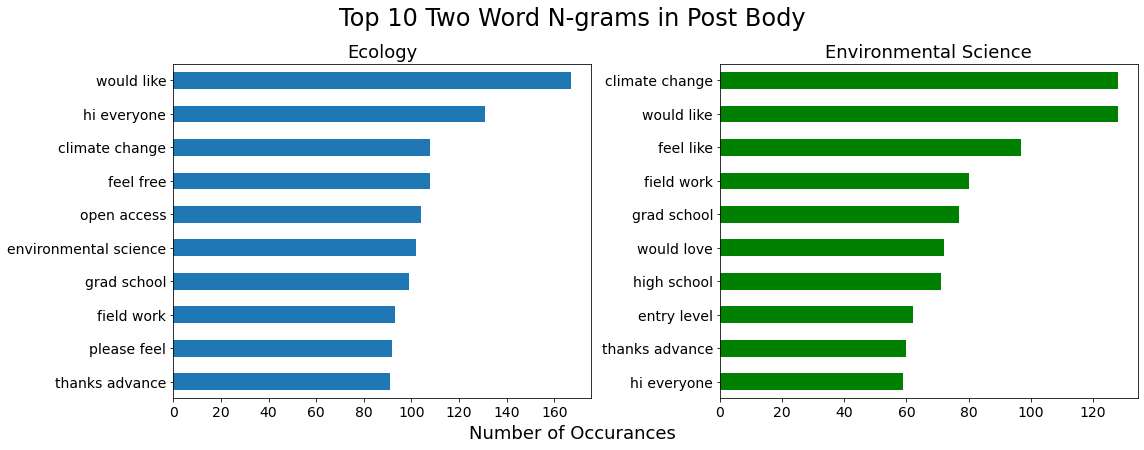

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
eco_x_n.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0], fontsize=14)
env_x_n.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1], fontsize=14, color='green')

ax[0].set_title('Ecology', fontsize=18)
ax[1].set_title('Environmental Science', fontsize=18)
ax[0].invert_yaxis()
ax[1].invert_yaxis()

fig.suptitle('Top 10 Two Word N-grams in Post Body', fontsize=24)
fig.text(0.5, -.02, 'Number of Occurances', ha='center', fontsize=18)
fig.tight_layout();

Next I wanted to check out title words for our data sets.

In [54]:
eco_titles_cvec = CountVectorizer(stop_words=eco_stopwords)
eco_titles = eco_titles_cvec.fit(eco_df['title'])
eco_titles = eco_titles_cvec.transform(eco_df['title'])
eco_titles = pd.DataFrame(eco_titles.todense(), columns=eco_titles_cvec.get_feature_names())

eco_titles.sum().sort_values(ascending=False).head(25)

help             177
species          112
ecological       112
advice           103
field            100
looking           99
question          99
article           92
week              91
research          90
open              87
career            82
school            81
job               74
anyone            74
need              73
conservation      69
data              68
would             68
good              68
work              68
environmental     67
plant             64
grad              64
science           62
dtype: int64

In [55]:
env_titles_cvec = CountVectorizer(stop_words=env_stopwords)
env_titles = env_titles_cvec.fit(env_df['title'])
env_titles = env_titles_cvec.transform(env_df['title'])
env_titles = pd.DataFrame(env_titles.todense(), columns=env_titles_cvec.get_feature_names())

env_titles.sum().sort_values(ascending=False).head(25)

advice         189
help           186
job            155
career         151
degree         147
major          129
looking        104
need            95
field           95
jobs            89
work            87
would           85
question        84
climate         83
environment     80
research        77
vs              77
change          77
masters         76
get             73
school          72
engineering     71
water           70
anyone          69
good            61
dtype: int64

In [56]:
eco_titles_cvec_n = CountVectorizer(stop_words=eco_stopwords, ngram_range=(2,2))
eco_titles_n = eco_titles_cvec_n.fit(eco_df['title'])
eco_titles_n = eco_titles_cvec_n.transform(eco_df['title'])
eco_titles_n = pd.DataFrame(eco_titles_n.todense(), columns=eco_titles_cvec_n.get_feature_names())

eco_titles_n.sum().sort_values(ascending=False).head(25)

article week             85
open article             79
grad school              42
climate change           32
field work               26
need help                24
environmental science    19
career advice            17
anyone know              17
discord server           15
graduate school          12
eco friendly             11
invasive species         11
book recommendations     11
high school              11
please help              10
plant species            10
looking advice            9
endangered species        8
career path               8
wildlife conservation     8
need advice               7
water quality             7
wildlife biology          7
fish wildlife             7
dtype: int64

In [57]:
env_titles_cvec_n = CountVectorizer(stop_words=env_stopwords, ngram_range=(2,2))
env_titles_n = env_titles_cvec_n.fit(env_df['title'])
env_titles_n = env_titles_cvec_n.transform(env_df['title'])
env_titles_n = pd.DataFrame(env_titles_n.todense(), columns=env_titles_cvec_n.get_feature_names())

env_titles_n.sum().sort_values(ascending=False).head(25)

climate change           53
career advice            28
need help                26
grad school              22
need advice              22
entry level              22
masters degree           17
env sci                  14
seeking advice           14
get job                  13
career path              12
global warming           12
please help              11
high school              11
field work               11
health safety            10
training announcement    10
looking advice            9
water quality             9
getting job               9
advice needed             9
masters program           9
graduate school           9
find job                  9
double major              9
dtype: int64

Visualize our top 10 title words.

Words in common:
1. Help
2. Advice
3. Field
4. Looking

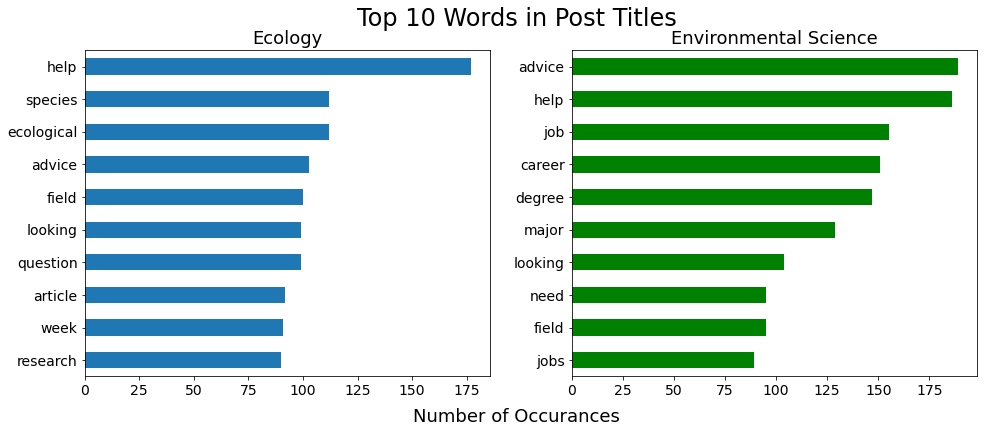

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
eco_titles.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0], fontsize=14)
env_titles.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1], fontsize=14, color='green')

ax[0].set_title('Ecology', fontsize=18)
ax[1].set_title('Environmental Science', fontsize=18)
ax[0].invert_yaxis()
ax[1].invert_yaxis()

fig.suptitle('Top 10 Words in Post Titles', fontsize=24)
fig.text(0.5, 0.02, 'Number of Occurances', ha='center', fontsize=18);

Visualize our top 10 n-grams in post titles.

N-grams in common:
1. Climate change
2. Need help
3. Career advice

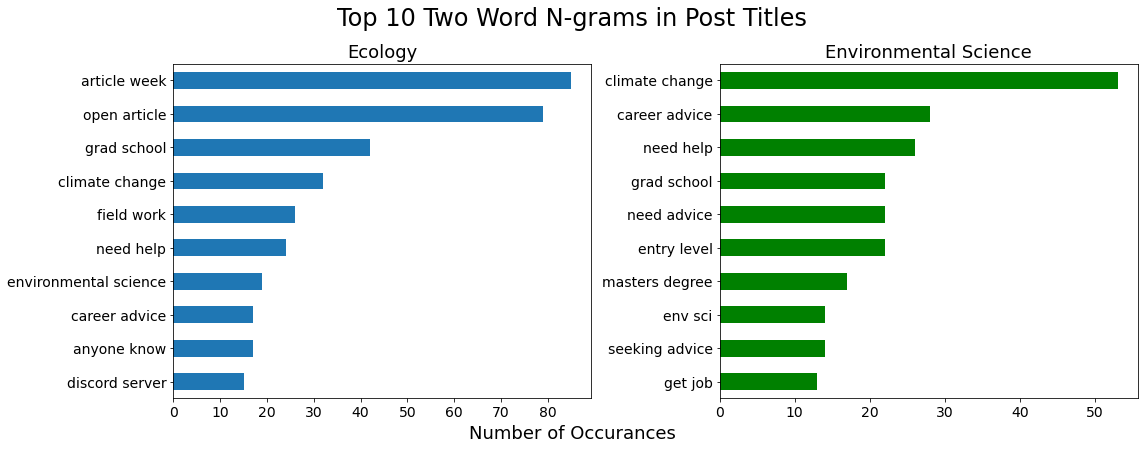

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
eco_titles_n.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0], fontsize=14)
env_titles_n.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1], fontsize=14, color='green')

ax[0].set_title('Ecology', fontsize=18)
ax[1].set_title('Environmental Science', fontsize=18)
ax[0].invert_yaxis()
ax[1].invert_yaxis()

fig.suptitle('Top 10 Two Word N-grams in Post Titles', fontsize=24)
fig.text(0.5, -.02, 'Number of Occurances', ha='center', fontsize=18)
fig.tight_layout();

I wanted to see if either subreddit happened to have a pattern of post and title lengths, looks like ecology posts tend to be longer and ecology titles are slightly longer.

In [60]:
print(f"Ecology body text mean char count: {eco_df['body_char_count'].mean()}")
print(f"Ecology body text mean word count: {eco_df['body_word_count'].mean()}")
print('---')
print(f"Env sci body text mean char count: {env_df['body_char_count'].mean()}")
print(f"Env sci body text mean char count: {env_df['body_word_count'].mean()}")
print('---')
print(f"Ecology title  mean char count: {eco_df['title_char_count'].mean()}")
print(f"Ecology title mean word count: {eco_df['title_word_count'].mean()}")
print('---')
print(f"Env sci title  mean char count: {env_df['title_char_count'].mean()}")
print(f"Env sci title mean word count: {env_df['title_word_count'].mean()}")

Ecology body text mean char count: 656.269643475251
Ecology body text mean word count: 106.8681204569055
---
Env sci body text mean char count: 426.8
Env sci body text mean char count: 72.48754208754208
---
Ecology title  mean char count: 58.92834890965732
Ecology title mean word count: 9.262720664589823
---
Env sci title  mean char count: 55.18249158249158
Env sci title mean word count: 8.563299663299663


In [61]:
trimmed_eco_df = eco_df.loc[eco_df['body_word_count'] < 600]

As we could have predicted from our means above, the distribution of word count in r/Ecology has lower count in its first bin, but the second bin shows a much higher number of words.

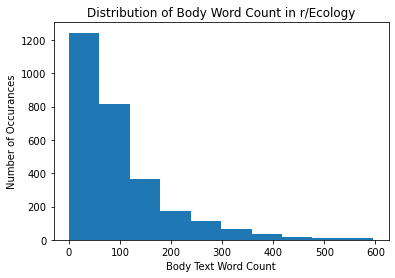

In [62]:
plt.hist(trimmed_eco_df['body_word_count'])
plt.xlabel('Body Text Word Count')
plt.ylabel('Number of Occurances')
plt.title('Distribution of Body Word Count in r/Ecology');

In [63]:
trimmed_env_df = env_df.loc[env_df['body_word_count'] < 600]

On the other side, the distribution of word count in r/Env Sci has a higher count in its first bin but lower counts going out after that.

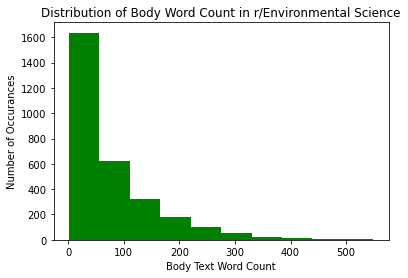

In [64]:
plt.hist(trimmed_env_df['body_word_count'], color='green')
plt.xlabel('Body Text Word Count')
plt.ylabel('Number of Occurances')
plt.title('Distribution of Body Word Count in r/Environmental Science');

In [128]:
import warnings
warnings.filterwarnings("ignore")

We can get an additional visualization of our post word count with a box plot showing us our quartiles, mean, and outliers.

r/Ecology has more short posts than r/Env Sci but also has more longer posts.

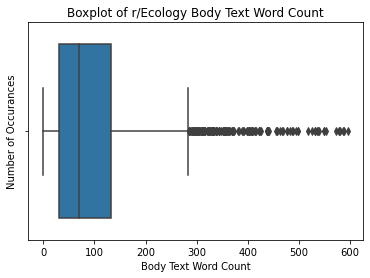

In [129]:
sns.boxplot(trimmed_eco_df['body_word_count'])
plt.xlabel('Body Text Word Count')
plt.ylabel('Number of Occurances')
plt.title('Boxplot of r/Ecology Body Text Word Count');

r/Env Sci's shortest posts are longer than r/Ecology but beyond that its posts are generally shorter.

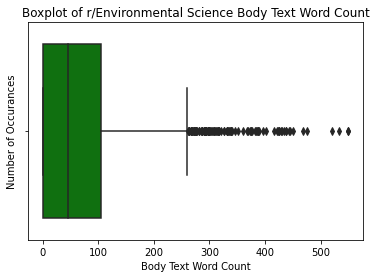

In [130]:
sns.boxplot(trimmed_env_df['body_word_count'], color='green')
plt.xlabel('Body Text Word Count')
plt.ylabel('Number of Occurances')
plt.title('Boxplot of r/Environmental Science Body Text Word Count');

I then got the means of the above box plots:

In [125]:
print(f"Trimmed r/Ecology word count mean is: {trimmed_eco_df['body_word_count'].mean()}")
print(f"Trimmed r/Env Sci word count mean is: {trimmed_env_df['body_word_count'].mean()}")

Trimmed r/Ecology word count mean is: 96.69281961471103
Trimmed r/Env Sci word count mean is: 69.63353617308992


Time to concat our dataframes before we run our train test split and begin modeling.  I'll be dropping the subreddit and created_utc columns.

In [65]:
combined_df = pd.concat([eco_df, env_df])
combined_df.drop(columns=['subreddit', 'created_utc'], inplace=True)
combined_df.head()

,title,selftext,body_char_count,body_word_count,title_char_count,title_word_count,target
1,Why isn't plant communication a more popular t...,"I first learned about this in my undergrad, un...",654,106,51,8,1
4,Video tutorial on the most important functions...,"Hi everyone, just a quick follow-up to my last...",633,56,66,11,1
6,Can you work for a nonprofit with a masters?,I tried to see if another person had asked thi...,851,159,44,9,1
7,Does atmospheric humidity enter the gaseous ph...,"From what I understand, the gas phase of soil ...",436,81,58,9,1
8,Is biological matter increasing?,"As I understand it, plants and protists kick a...",396,68,32,4,1


<a id='modeling'></a>
### Modeling
---

Time to setup our X and y variables.

In [66]:
X = combined_df['selftext']
y = combined_df['target']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

Create a new master stopwords list with both sets put together, however, leaving in words like ecology, environmental, and science.

In [68]:
base_stop_words = nltk.corpus.stopwords.words('english')
master_stop_words = ['www', 'https', 'com', 'amp', 'x200b', 'removed']
add_stop_words(master_stop_words, base_stop_words)

Get a baseline accuracy from the mean of our target column: 50.7%

In [69]:
y_test.value_counts(normalize=True)[0]

0.5071672354948805

<a id='naive-bayes'></a>
#### **Naïve Bayes**

**Model #1**

Our first model will use count vectorizing with a Naïve Bayes model.

In [70]:
cvec_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

cvec_pipe_params = {
    'cvec__max_features': [None, 3000, 4000, 5000],
    'cvec__stop_words': [None, master_stop_words],
    'cvec__min_df': [2, 3],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [71]:
gs_cvec = GridSearchCV(
    cvec_pipe,
    param_grid = cvec_pipe_params,
    cv=5,
    n_jobs=-1
)

gs_cvec.fit(X_train, y_train)
print(gs_cvec.best_params_)
print(gs_cvec.best_score_)

{'cvec__max_features': None, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ['www', 'https', 'com', 'amp', 'x200b', 'removed', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'wh

Our score for a cvec/NB model is 77.5%.

In [72]:
gs_cvec.score(X_test, y_test)

0.7747440273037542

**Model #2**

Our second model will use TF-IDF vectorizing and utilize a Naïve Bayes model.

In [73]:
tvec = TfidfVectorizer()

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

pipe_params = {
    'tvec__max_features': [None, 5000, 6000, 7000],
    'tvec__stop_words': [None, master_stop_words],
    'tvec__min_df': [2, 3],
    'tvec__ngram_range': [(1,1), (1,2)]
}

Our best parameters for the NB model are:
1. Max features: None
    - I intially ommited the default `max_features` setting and only using 5000 - 7000 thinking more would be better but it appears the algorithm is smarter than I gave it credit for, performing best with the default.
2. Min_df: 3
    - Nothing shocking here, this ensures repeated words bear more importance to our model
3. N-gram range: 1, 2
    - Slightly surprised, but not really.  Two word pairs didn't help our predictive power much here.
4. Stop words: master_stop_words
    - Our custom stop words list performed the best

In [74]:
gs_tvec = GridSearchCV(
    pipe_tvec,
    param_grid = pipe_params,
    cv=5,
    n_jobs=-1
)

gs_tvec.fit(X_train, y_train)
print(gs_tvec.best_params_)
print(gs_tvec.best_score_)

{'tvec__max_features': None, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': ['www', 'https', 'com', 'amp', 'x200b', 'removed', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'wh

Time to score our test set, 79.9% 

In [75]:
gs_tvec.score(X_test, y_test)

0.7972696245733788

<a id='random-forest'></a>
#### **Random Forest Model**

**Model #3**

Our third model will be a random forest with count vectorizer.

In [76]:
rf = RandomForestClassifier()

In [77]:
cvec_pipe_2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [82]:
cvec_pipe_params = [{
    'cvec__max_features': [None, 5000, 6000, 7000],
    'cvec__stop_words': [None, master_stop_words],
    'cvec__min_df': [2, 3],
    'cvec__ngram_range': [(1,1), (1,2)]
},
{
    'rf__n_estimators': [250, 300, 350],
    'rf__max_depth': [None, 1, 2, 3],
    'rf__max_features': ['sqrt', .5]
}]

Our best parameters for the random forest model are:
1. N-estimators: 250
2. Max depth: None (default)
3. Max features: .5

In [83]:
gs_cvec_2 = GridSearchCV(cvec_pipe_2, param_grid=cvec_pipe_params, cv=5, n_jobs=-1, verbose=1)
gs_cvec_2.fit(X_train, y_train)
print(gs_cvec_2.best_score_)
print(gs_cvec_2.best_params_)

Fitting 5 folds for each of 44 candidates, totalling 220 fits
0.7994985500711359
{'rf__max_depth': None, 'rf__max_features': 0.5, 'rf__n_estimators': 350}


Random forest with cvec seems to be our best model so far with a score of 80.4%

In [94]:
gs_cvec_2.score(X_test, y_test)

0.8061433447098976

**Model #4**

Our fourth model will be another random forest but we'll use TF-IDF this time.

In [53]:
tvec_pipe_2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

In [54]:
tvec_pipe_params_2 = [{
    'tvec__max_features': [None, 5000, 6000, 7000],
    'tvec__stop_words': [None, master_stop_words],
    'tvec__min_df': [2, 3],
    'tvec__ngram_range': [(1,1), (1,2)]
},
{
    'rf__n_estimators': [100, 150, 200, 250],
    'rf__max_depth': [None, 1, 2, 3],
    'rf__max_features': ['sqrt', 'log2', .5],
    'rf__min_impurity_decrease': [0, .025],
}]

In [55]:
gs_tvec_2 = GridSearchCV(tvec_pipe_2, param_grid=tvec_pipe_params_2, cv=5, n_jobs=-1, verbose=1)
gs_tvec_2.fit(X_train, y_train)
print(gs_tvec_2.best_score_)
print(gs_tvec_2.best_params_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
0.7974492136176696
{'rf__max_depth': None, 'rf__max_features': 0.5, 'rf__min_impurity_decrease': 0, 'rf__n_estimators': 100}


About even with our first random forest, slightly worse with an 80.4%.

In [56]:
gs_tvec_2.score(X_test, y_test)

0.8006825938566553

<a id='svm'></a>
#### **SVM**

**Model #5**

We will build a support vector machine model with cvec.

In [63]:
svc_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('svc', SVC())
])

In [65]:
svc_params = [{
    'svc__C': np.linspace(0.0001, 1, 20),
    'svc__kernel': ['rbf', 'poly', 'sigmoid'],
    'svc__degree': [2, 3],
    'svc__gamma': ['scale', 'auto']
},
{
    'cvec__max_features': [None, 5000, 6000],
    'cvec__stop_words': [None, master_stop_words],
    'cvec__min_df': [2, 3],
    'cvec__ngram_range': [(1,1), (1,2)]
}]

svc_gs = GridSearchCV(svc_pipe, svc_params, cv=5, n_jobs=-1, verbose=1)

svc_gs.fit(X_train, y_train)

print(svc_gs.best_score_)
print(svc_gs.best_params_)

Fitting 5 folds for each of 264 candidates, totalling 1320 fits
0.7894853594761079
{'cvec__max_features': None, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None}


This model took a long time to run and unfortunately didn't yield any meaningful increase in score.

In [67]:
svc_gs.score(X_test, y_test)

0.7890784982935154

**BONUS**

All of the above models used body text, I want to see how our best performing model, random forest with cvec, will do using title text.

In [70]:
X2 = combined_df['title']
y2 = combined_df['target']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [72]:
title_cvec_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [73]:
title_cvec_pipe_params = [{
    'cvec__max_features': [None, 5000, 6000],
    'cvec__stop_words': [None, master_stop_words],
    'cvec__min_df': [2, 3],
    'cvec__ngram_range': [(1,1), (1,2)]
},
{
    'rf__n_estimators': [100, 150, 200, 250],
    'rf__max_depth': [None, 1, 2, 3],
    'rf__max_features': ['sqrt', 'log2', .5],
    'rf__min_impurity_decrease': [0, .025],
}]

In [74]:
title_cvec = GridSearchCV(title_cvec_pipe, param_grid=title_cvec_pipe_params, cv=5, n_jobs=-1, verbose=1)
title_cvec.fit(X_train, y_train)
print(title_cvec.best_score_)
print(title_cvec.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
0.7992705004910841
{'rf__max_depth': None, 'rf__max_features': 0.5, 'rf__min_impurity_decrease': 0, 'rf__n_estimators': 200}


Looks like this model is about on par with it's body text cousin with a score of 80.5%.

In [75]:
title_cvec.score(X_test, y_test)

0.8054607508532423

<a id='scoring-and-evaluation'></a>
### Scoring and Evaluation
---

Our best model used count vectorizing and a random forest. I will evaluate and score it below with a confusion matrix.

In [89]:
gs_cvec_2.score(X_test, y_test)

0.8040955631399317

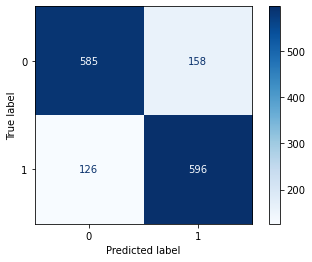

In [86]:
preds = gs_cvec_2.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

plot_confusion_matrix(gs_cvec_2, X_test, y_test, cmap='Blues', values_format='d');

1. Accuracy: 80.4%
    - Acceptable, I'd be curious if a KNN or logistic regression would possibly up our accuracy.
2. Precision: 78.7%
    - Our lowest metric, but I'm ok with that since it's of lease concern to us for what we're using the model for.
3. Recall: 82.5%
    - I'm happy with this score since it's our model's ability to find all positive samples.

In [87]:
print('Model accuracy is:', metrics.accuracy_score(y_test, preds))
print('Model precision is:', metrics.precision_score(y_test, preds))
print('Model recall is:', metrics.recall_score(y_test, preds))

Model accuracy is: 0.8061433447098976
Model precision is: 0.7904509283819628
Model recall is: 0.8254847645429363


<a id='conclusion-and-inferences'></a>
### Conclusion and Inferences
---

**Conclusion**

All scores surpassed our null hypothesis fo 50.7 with a satisfactory overall accuracy of 80.4 and recall of 82.5.

With additional posts I think we could possibly squeeze a bit more performance out of our models, however, if we call the EDA there were a lot of similarities in our posts so 80.4% accuracy is great.  Perhaps a KNN or logisitic regression would perform better but with the time allotted and how resource/time intensive running some of these gridsearches is, we're going to stick with this single model for now.

**Inferences**

From our intial EDA we observed that both subreddits have a large number of posts pertaining to questions about jobs/work as well as questions about higher education in the fields of ecology and environmental science.  From our NLP, it appears that that the environmental science subreddit tends to be slightly more focused on work and educational endeavors where as the ecology subreddit has more posts about research, field experience, and plant and animal species.